# Modelling notebook 2: Random Forest

In this notebook, we build Random Forest models for predicting fog. The data is split into a trian/validation set to make modelling decisions, and an unseen test set for checking the generalisation error of the models.

<br>

**Train-Valid:** 2011-2019  
**Test:** 2020 and 2021

Contents:
- Feature selection using cross validated Random Forest gain importace values as a measure of feature importance.
Feature importances are calculated using time-series splitted cross validation. Based on this we pick the feature list. 

- We then do some testing, adding lagged features and checking the impact on performance. 

- Finally, we tune the parameters of RF model and export.

## 1. Import Packages & Data

In [ ]:
! pip install -U neptune-client
!pip install -U neptune-sklearn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.8/443.8 KB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 54.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.

In [ ]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.2.1

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 53.1 MB/s eta 0:00:00


In [ ]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.2.1.


In [ ]:
# data processing
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import missingno
from scipy import stats

# modelling
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, \
RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from scipy.stats import uniform, randint

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# other
from tqdm import tqdm
import pickle
import os
import sys
import neptune.new as neptune
import neptune.new.integrations.sklearn as npt_utils

seed=42

In [ ]:
# Initiate neptune model
#model = neptune.init_model(
#    name="Random Forest",
#    key="RF", 
#    project="swiatej2/fyp", 
#    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjOTQxYjBkZS0zN2Y1LTRhYTQtOGQ1My03YTAxODJkM2E1OWMifQ==", # your credentials
#)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing data and helper functions from directories dependent on which is available

joseph_path = '/content/drive/My Drive/DS_Modules/CA4021 (Final Year Project)/' # Joseph
julita_path = '/content/drive/My Drive/CA4021 (Final Year Project)/' # Julita

if os.path.exists(joseph_path):
  print("Importing from DS_Modules/CA4021")
  sys.path.append(os.path.join(joseph_path, 'scripts'))
  path = joseph_path

elif os.path.exists(julita_path):
  print("Importing directly from CA4021 folder")
  sys.path.append(sys.path.append(os.path.join(julita_path, 'scripts')))
  path = julita_path

Importing from DS_Modules/CA4021


In [ ]:
# import helper functions from aux file (prevents too much function definitions in the notebook)
from aux_functions import missing_percentages, plot_dist_discrete, plot_dist_continuous, \
plot_vis_discrete, plot_vis_continuous, month_vplot

from aux_functions_ml import preprocess, manual_cross_validate, get_feat_importance_df, \
performance_report, calc_mean_importance, plot_importance, heidke_skill_score,score_model

In [ ]:
# import train/valid and test sets
df_train = pd.read_csv(os.path.join(path, 'data/train_data.csv'))
df_train.index=pd.to_datetime(df_train.date_time)
df_train.date_time = df_train.index

df_test = pd.read_csv(os.path.join(path, 'data/test_data.csv'))
df_test.index=pd.to_datetime(df_test.date_time)
df_test.date_time = df_test.index

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

print("Train/valid:", df_train.shape)
print("Test:", df_test.shape)

Train/valid: (78888, 57)
Test: (17544, 57)


In [ ]:
df_train.head()

,date_time,year,month,day,hour,date,dir,speed,vis,ww,w,pchar,ptend,cbl,msl,drybulb,wetbulb,dewpt,vp,rh,clow,cmedium,chigh,nlc,ntot,hlc,nsig1,tsig1,hsig1,nsig2,tsig2,hsig2,nsig3,tsig3,hsig3,nsig4,tsig4,hsig4,ceiling,dos,weather,duration,rainfall,sunshine,tabdir,tabspeed,pweather,dni,vis_hr1,target_hr1,fog_state,season,temp_dew_dist,rainfall12hma,fog_formation,fog_dissipation,transition
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,2011,1,1,0,01-Jan-2011 00:00:00,27,7,9000,10,22,5,0.1,1017.1,1027.8,5.5,4.6,3.3,7.8,86,5.0,0.0,0.0,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,26,6,0,0,9000.0,0,no fog,winter,2.2,0.0,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,2011,1,1,1,01-Jan-2011 01:00:00,28,6,9000,10,22,5,0.0,1017.1,1027.8,5.1,4.4,3.4,7.8,89,5.0,0.0,0.0,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,28,6,0,0,8000.0,0,no fog,winter,1.7,0.0,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,2011,1,1,2,01-Jan-2011 02:00:00,27,6,8000,10,22,8,0.2,1016.8,1027.5,5.3,4.0,2.1,7.1,80,5.0,0.0,0.0,7,7,22,7,6,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,27,7,0,0,8000.0,0,no fog,winter,3.2,0.0,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,2011,1,1,3,01-Jan-2011 03:00:00,25,7,8000,10,22,7,0.5,1016.6,1027.3,5.2,4.6,3.7,8.0,90,5.0,0.0,0.0,7,7,23,7,6,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,27,7,0,0,8000.0,0,no fog,winter,1.5,0.0,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,2011,1,1,4,01-Jan-2011 04:00:00,28,7,8000,10,22,6,0.5,1016.6,1027.3,5.1,4.7,4.1,8.2,94,5.0,0.0,0.0,7,7,24,7,6,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,0.0,0,0.0,0.0,0.0,27,7,0,0,9000.0,0,no fog,winter,1.0,0.0,0,0,0


In [ ]:
# LEAVING OUT w, ww, pweather and weather because of OH encoding sparsity

metadata = ['date', 'date_time', 'year', 'month', 'day', 'hour', 'season']
indicator = [col for col in df_train.columns if col[0] == 'i']
constant = [var for var in df_train.columns if len(df_train[var].value_counts()) == 1]
codes = ['sp1', 'sp2', 'sp3', 'sp4', 'wwa', 'wa', 'w' ,'ww', 'pweather', 'weather']
excluded = indicator + constant + codes + ['rgauge', 'sog', 'tabspeed', 'msl']
vis_vars=['target_hr1', 'vis_hr1', 'fog_formation', 'fog_dissipation', 'transition']
target = 'target_hr1'

categorical=['fog_state', 'season', 'tsig1', 'tsig2', 'tsig3', 'pchar'] #'w', 'ww', 'pweather',
             #'weather']
discrete = [var for var in df_train.columns if len(df_train[var].unique()) < 15 and 
             var not in excluded + categorical + metadata + codes + indicator + vis_vars]

continuous = [var for var in df_train.columns if var not in discrete + excluded + categorical + metadata + codes + indicator + vis_vars]
numerical = discrete+continuous
# conservative list of variables known to have an impact on fog formation.
# the other lists are too big for certain visualisations
fog_vars = ['rainfall', 'drybulb', 'cbl', 'ntot', 'dni', 'dewpt', 'speed', 'dir', 'rh']

## 2. Feature Selection 

In this section, we check the gain importance for each variable using Random Forest. These results are averaged out using cross validation, and the performance of the model is assessed.

A final set of features is selected using the importance scores.

In [ ]:
dates = df_train.date_time
X = df_train[numerical + categorical + vis_vars].reset_index(drop=True)
y = X.pop(target)

In [ ]:
# debugging
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=seed)
print("-" * 100)
X_train_p, X_valid = preprocess(X_train, X_valid, cat_vars=categorical, num_vars=numerical, cat_encoder='oh')
X_train_p.head()

----------------------------------------------------------------------------------------------------


,clow,cmedium,chigh,nlc,ntot,nsig1,nsig2,nsig3,nsig4,tsig4,duration,sunshine,dir,speed,vis,ptend,cbl,drybulb,wetbulb,dewpt,vp,rh,hlc,hsig1,hsig2,hsig3,hsig4,ceiling,dos,rainfall,tabdir,dni,temp_dew_dist,rainfall12hma,fog_state_fog,fog_state_no fog,season_autumn,season_spring,season_summer,season_winter,tsig1_0,tsig1_1,tsig1_2,tsig1_3,tsig1_4,tsig1_6,tsig1_7,tsig1_8,tsig1_9,tsig2_0.0,tsig2_1.0,tsig2_2.0,tsig2_3.0,tsig2_4.0,tsig2_5.0,tsig2_6.0,tsig2_7.0,tsig2_8.0,tsig2_9.0,tsig3_0.0,tsig3_1.0,tsig3_2.0,tsig3_3.0,tsig3_4.0,tsig3_5.0,tsig3_6.0,tsig3_7.0,tsig3_8.0,tsig3_9.0,pchar_0,pchar_1,pchar_2,pchar_3,pchar_4,pchar_5,pchar_6,pchar_7,pchar_8
23939,0.157474,-0.477146,-0.628931,0.907394,0.592403,0.313530,1.031267,-0.765498,-0.043149,-0.039436,-0.416261,-0.209465,-0.928211,-0.469562,-0.958545,-0.945974,0.177002,1.265908,1.454086,1.585501,1.763963,0.221055,-0.415021,-0.415119,-0.601713,-0.516163,-0.034592,-0.609330,-0.03421,-0.20967,-0.941575,1.340872,-0.276816,-0.338362,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11407,1.163045,1.275959,1.487995,-0.552570,-0.284485,-0.506373,-0.283505,-0.765498,-0.043149,-0.039436,-0.416261,0.718635,0.769422,0.252956,2.182355,-0.853002,-1.733127,-1.000529,-0.922103,-0.712943,-0.766941,0.809214,-0.002964,-0.003052,-0.004084,-0.516163,-0.034592,0.701554,-0.03421,-0.20967,0.782022,1.220059,-0.783520,-0.198496,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27333,-1.350882,-0.477146,-0.628931,-0.552570,-1.161373,-0.506373,-1.160020,-0.765498,-0.043149,-0.039436,-0.416261,-0.518832,0.405643,3.143029,-0.260567,4.353464,-3.064429,-1.301384,-1.538998,-1.850786,-1.555794,-0.955261,-0.297291,-0.297386,-0.482187,-0.516163,-0.034592,-0.754984,-0.03421,-0.20967,0.412680,-0.852335,0.694366,1.619758,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59969,1.163045,-0.477146,1.487995,-0.917560,-0.722929,-0.506373,-0.283505,-0.765498,-0.043149,-0.039436,-0.416261,-0.518832,-0.079395,-1.192080,0.437410,0.448615,-0.385287,-0.418877,-0.465143,-0.485374,-0.602597,-0.199058,-0.002964,-0.003052,2.984065,-0.516163,-0.034592,2.886360,-0.03421,-0.20967,0.043337,-0.852335,0.018761,-0.373328,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2805,-2.859238,-0.477146,0.429532,-1.647542,-2.038261,-0.506373,-1.598277,-0.765498,-0.043149,-0.039436,-0.416261,-0.518832,-1.655768,-1.192080,0.088421,-1.038947,1.119662,-0.559276,-0.465143,-0.303319,-0.405383,0.641169,8.179305,8.179424,-0.751121,-0.516163,-0.034592,-0.754984,-0.03421,-0.20967,-1.557146,-0.852335,-0.614619,-0.373328,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
model = RandomForestClassifier(random_state=seed)

In [ ]:
df_train.loc[(df_train.transition==1), ['transition','fog_state']]

df_train.loc[df_train.index >= '2011-01-20 18:00', ['transition', 'fog_state']]

,transition,fog_state
date_time,,
2011-01-20 18:00:00,0,no fog
2011-01-20 19:00:00,0,no fog
2011-01-20 20:00:00,1,fog
2011-01-20 21:00:00,0,fog
2011-01-20 22:00:00,0,fog
...,...,...
2019-12-31 19:00:00,0,no fog
2019-12-31 20:00:00,0,no fog
2019-12-31 21:00:00,0,no fog


In [ ]:
vars_sel = ['vis', 'temp_dew_dist', 'rh', 'ceiling', 'duration', 'hsig2', 'dni', 
                  'dewpt', 'drybulb', 'cbl', 'hlc', 'ntot', 'speed', 'vp', 'pchar','dir']
num_vars_sel = [var for var in vars_sel if var in discrete+continuous]
cat_vars_sel = [var for var in vars_sel if var in categorical]

In [ ]:
full_model_scores, gain_importance_tables, _ = manual_cross_validate(model, X, y, 
                                                                     cat_vars=categorical, 
                                                                     num_vars=numerical, 
                                                                     folds=5,
                                                                     cat_encoder='oe',
                                                                     calc_feature_importance=True)

Fold : 1
training size: (13148, 40)
test size: (13148, 41)
[[13013    23]
 [   48    64]]
****************************************************************************************************
Fold : 2
training size: (26296, 40)
test size: (13148, 41)
[[12955    32]
 [   73    88]]
****************************************************************************************************
Fold : 3
training size: (39444, 40)
test size: (13148, 41)
[[13029    24]
 [   35    60]]
****************************************************************************************************
Fold : 4
training size: (52592, 40)
test size: (13148, 41)
[[13043    16]
 [   54    35]]
****************************************************************************************************
Fold : 5
training size: (65740, 40)
test size: (13148, 41)
[[13081    12]
 [   35    20]]
****************************************************************************************************


In [ ]:
full_model_scores_oe, gain_importance_tables_oe, _ = manual_cross_validate(model, X, y, 
                                                                      cat_vars=categorical, 
                                                                      num_vars=numerical, 
                                                                      folds=5,
                                                                      cat_encoder='oe',
                                                                      calc_feature_importance=True)

Fold : 1
training size: (13148, 40)
test size: (13148, 41)
[[13013    23]
 [   48    64]]
****************************************************************************************************
Fold : 2
training size: (26296, 40)
test size: (13148, 41)
[[12955    32]
 [   73    88]]
****************************************************************************************************
Fold : 3
training size: (39444, 40)
test size: (13148, 41)
[[13029    24]
 [   35    60]]
****************************************************************************************************
Fold : 4
training size: (52592, 40)
test size: (13148, 41)
[[13043    16]
 [   54    35]]
****************************************************************************************************
Fold : 5
training size: (65740, 40)
test size: (13148, 41)
[[13081    12]
 [   35    20]]
****************************************************************************************************


In [ ]:
# comparing one hot encoding and ordinal encoding performance
# result: one hot encoding outperformed ordinal encoding
print("One hot encoded:")
performance_report(full_model_scores)
print("\nOrdinal encoded:")
performance_report(full_model_scores_oe)

One hot encoded:
Validation Scores
------------------------------
f1_score
Scores: [66.02, 65.51, 65.93, 56.76, 48.84]
Mean: 60.612

heidke_skill_score
Scores: [0.6575, 0.6513, 0.657, 0.5652, 0.4868]
Mean: 0.604

transition_f1_score
Scores: [60.38, 57.89, 57.14, 66.67, 56.0]
Mean: 59.616

transition_hss_score
Scores: [0.3918, 0.3389, 0.3684, 0.5328, 0.4081]
Mean: 0.408


Ordinal encoded:
Validation Scores
------------------------------
f1_score
Scores: [64.32, 62.63, 67.04, 50.0, 45.98]
Mean: 57.994

heidke_skill_score
Scores: [0.6405, 0.6224, 0.6681, 0.4975, 0.4581]
Mean: 0.577

transition_f1_score
Scores: [60.0, 52.63, 65.0, 59.46, 48.0]
Mean: 57.018

transition_hss_score
Scores: [0.4044, 0.2563, 0.4909, 0.4432, 0.3004]
Mean: 0.379



## Feature Engineering Tests

In this section, we try several feature engineering ideas and check the impacts of these variables on model performance. In the previous section, we already saw that the temp_dew_dst variable was a good addition. We also considered adding cloud presence indicators, but this and many other cloud volume properties are encoded by ntot, nsigX, nlc, and clow/medium/high.

This section will mainly be used to test lagged features.


## Hyperparameter Tuning

In this section, we hyperparameter tune our random forest decision tree classifier using a cross-validated randomised search approach. This will probably be updated later to a different method later.

In [ ]:
# creating training sets using only the selected features
X_train, X_test = preprocess(df_train, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel, cat_encoder='oh')
# create training data using all the variables df_train (for comparison)
X_train_all, X_test_all = preprocess(df_train, df_test, 
                                     cat_vars=categorical, num_vars=continuous+discrete, cat_encoder='oh')
y_train = y.copy()
y_test = df_test[target]

In [ ]:
# for compatibility with TimeSeriesSplit
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
X_train.head()

,vis,temp_dew_dist,rh,ceiling,duration,hsig2,dni,dewpt,drybulb,cbl,hlc,ntot,speed,vp,dir,pchar_0,pchar_1,pchar_2,pchar_3,pchar_4,pchar_5,pchar_6,pchar_7,pchar_8
0,-1.376079,-0.362191,0.305680,-0.432978,-0.416469,-0.749357,-0.855241,-0.786384,-0.865935,1.170655,-0.002102,0.592468,-0.652624,-0.804416,0.770863,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.376079,-0.573671,0.557907,-0.432978,-0.416469,-0.749357,-0.855241,-0.763574,-0.946414,1.170655,-0.002102,0.592468,-0.833040,-0.804416,0.892206,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.445887,0.060768,-0.198772,-0.432978,-0.416469,-0.749357,-0.855241,-1.060103,-0.906174,1.145849,-0.002102,0.592468,-0.833040,-1.035018,0.770863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.445887,-0.658263,0.641982,-0.418409,-0.416469,-0.749357,-0.855241,-0.695144,-0.926294,1.129312,0.027427,0.592468,-0.652624,-0.738529,0.528175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.445887,-0.869742,0.978284,-0.403841,-0.416469,-0.749357,-0.855241,-0.603904,-0.946414,1.129312,0.056956,0.592468,-0.652624,-0.672643,0.892206,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
X_test.head()

,vis,temp_dew_dist,rh,ceiling,duration,hsig2,dni,dewpt,drybulb,cbl,hlc,ntot,speed,vp,dir,pchar_0,pchar_1,pchar_2,pchar_3,pchar_4,pchar_5,pchar_6,pchar_7,pchar_8
0,-0.259153,-0.108416,-0.030621,-0.432978,-0.416469,-0.749357,-0.855241,-0.603904,-0.584257,1.377368,-0.002102,0.592468,-1.193872,-0.672643,0.164144,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.608192,0.060768,-0.198772,-0.316430,-0.416469,-0.301451,-0.855241,-0.695144,-0.584257,1.336026,-0.061160,0.592468,-1.013456,-0.771472,0.164144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.608192,0.356839,-0.535074,-0.345567,-0.416469,-0.331311,-0.855241,-0.991673,-0.704976,1.319489,-0.061160,0.592468,-0.833040,-0.969132,0.285487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.957232,-0.150712,-0.030621,-0.753485,-0.416469,-0.376102,-0.855241,-1.082913,-1.026894,1.261609,-0.061160,-1.160488,-1.374288,-1.067962,-0.563919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.957232,-0.742854,0.641982,-0.753485,-0.416469,-0.749357,-0.855241,-1.698781,-1.851809,1.187192,-0.208805,-2.036967,-1.554704,-1.463281,0.406831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# !!!! Do not rerun!
# Output is saved into file

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_model = RandomForestClassifier(random_state=seed)
time_split = TimeSeriesSplit(n_splits = 5)
rf_search = RandomizedSearchCV(rf_model,param_distributions=random_grid, random_state=seed, n_iter=10, cv=time_split, verbose=3, n_jobs=1, return_train_score=True)

rf_search.fit(X_train, y_train)
# Save the object to a file
with open(os.path.join(path, 'results/rf_hyperparam_search3.pickle'), "wb") as file:
    pickle.dump(rf_search, file)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=(train=0.998, test=0.993) total time=   1.7s
[CV 2/5] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=(train=0.997, test=0.992) total time=   3.6s
[CV 3/5] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=(train=0.997, test=0.995) total time=   7.6s
[CV 4/5] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=(train=0.997, test=0.995) total time=  10.7s
[CV 5/5] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=(train=0.997, test=0.996) total time=  14.0s
[CV 1/5] END bootstrap=False, max_depth=30, max_features=sqrt, m

In [ ]:
rf_search.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [ ]:
rf_search.cv_results_

In [ ]:
rf_search.cv_results_['params']

In [ ]:
# We will finetune the hyperparameters with Gridsearch
# DO NOT RERUN - RESULTS SAVED

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [False],
    'max_depth': [20, 30, 40],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [2, 4],
    'n_estimators': [900, 1000, 1100]
}
# Create a base model
rf_model = RandomForestClassifier(random_state=seed)
time_split = TimeSeriesSplit(n_splits = 5)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model,param_grid=param_grid,
                           cv=time_split, n_jobs=-1, verbose=3,return_train_score=True)

grid_search.fit(X_train, y_train)
grid_search.best_params_

# Save the object to a file
with open(os.path.join(path, 'results/rf_hyperparam_search2.pickle'), "wb") as file:
    pickle.dump(grid_search, file)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
# load hyperparameter search
with open(os.path.join(path, 'results/rf_hyperparam_search2.pickle'), 'rb') as file:
  rf_search = pickle.load(file)

In [ ]:
rf_search.best_params_

{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 800}

In [ ]:
best_params ={'bootstrap': False,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 800}

In [ ]:
grid_search.cv_results_

##  Final Evaluation

First we check the performance of the final model (features selected and hyperparameter tuned), and compare it to the initial default rf model (all features) using cross validation on the train/valid set (called this the validation model).

**Result:** The initial model outperforms the validation model on the train_valiation set.

After that, we train the final model with the all the train/valid data, and test it out on the unseen test set.


Fold : 1
training size: (13148, 16)
test size: (13148, 16)
[[13022    14]
 [   64    48]]
****************************************************************************************************
Fold : 2
training size: (26296, 16)
test size: (13148, 16)
[[12954    33]
 [   72    89]]
****************************************************************************************************
Fold : 3
training size: (39444, 16)
test size: (13148, 16)
[[13029    24]
 [   39    56]]
****************************************************************************************************
Fold : 4
training size: (52592, 16)
test size: (13148, 16)
[[13044    15]
 [   52    37]]
****************************************************************************************************
Fold : 5
training size: (65740, 16)
test size: (13148, 16)
[[13081    12]
 [   34    21]]
****************************************************************************************************


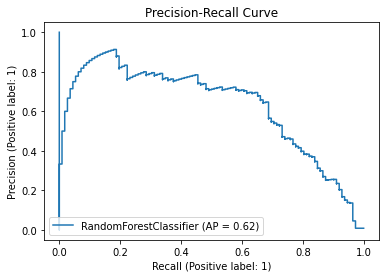

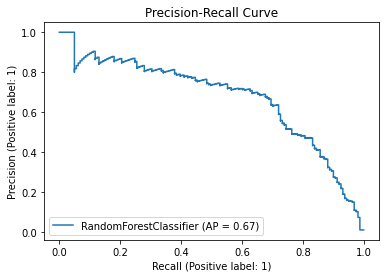

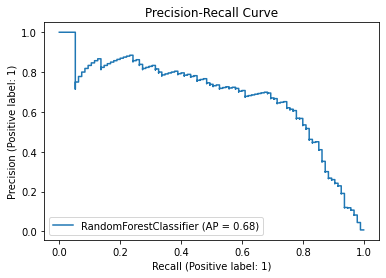

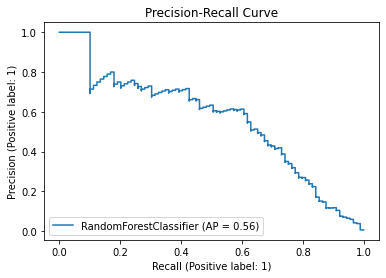

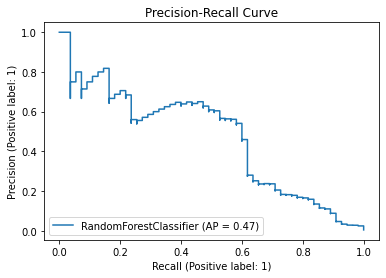

In [ ]:
validation_model = RandomForestClassifier(**rf_search.best_params_, random_state=seed)
validation_model_scores, _, _ = manual_cross_validate(model=validation_model, 
                                                 X=X, y=y,
                                                 num_vars=num_vars_sel,
                                                 cat_vars=cat_vars_sel,              
                                                 folds=5, 
                                                 calc_feature_importance=False,
                                                 cat_encoder='oe')

In [ ]:
# performance of model using all variables and no hyperparameter tuning
performance_report(full_model_scores)

Validation Scores
------------------------------
f1_score
Scores: [64.32, 62.63, 67.04, 50.0, 45.98]
Mean: 57.994

heidke_skill_score
Scores: [0.6405, 0.6224, 0.6681, 0.4975, 0.4581]
Mean: 0.577

transition_f1_score
Scores: [27.03, 25.0, 29.47, 25.29, 19.67]
Mean: 25.292

transition_hss_score
Scores: [-0.1341, -0.199, -0.1652, -0.0744, -0.1451]
Mean: -0.144



In [ ]:
# after feature selection and hyperparameter tuning
performance_report(validation_model_scores)

Validation Scores
------------------------------
f1_score
Scores: [57.14, 60.87, 62.92, 54.17, 42.86]
Mean: 55.592

heidke_skill_score
Scores: [0.5686, 0.6047, 0.6267, 0.5393, 0.4269]
Mean: 0.553

transition_f1_score
Scores: [18.37, 28.21, 24.74, 27.59, 13.79]
Mean: 22.540

transition_hss_score
Scores: [-0.1533, -0.1238, -0.2586, -0.0413, -0.1858]
Mean: -0.153



In [ ]:
# creating training sets using only the selected features
X_train, X_test = preprocess(df_train, df_test, cat_vars=cat_vars_sel, num_vars=num_vars_sel, cat_encoder='oh')

y_train = y.copy()
y_test = df_test[target]

In [ ]:
# Finally, on the unseen test set
final_model = RandomForestClassifier(**grid_search.best_params_,random_state=seed)
final_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=80, min_samples_leaf=4,
                       min_samples_split=12, n_estimators=800, random_state=42)

In [ ]:
final_scores = score_model(final_model, X_train, X_test, y_train, y_test, df_test)

print("Final model performance:")
print("-"*100)
print("F1 score: {}\nHeidke Skill Score:{}".format(final_scores['f1'],
                                                   final_scores['hss']))
print()
print("Transition F1 score: {}\nTransition Heidke Skill Score:{}".format(final_scores['transition_f1'], 
                                                                         final_scores['transition_hss']))

Final model performance:
----------------------------------------------------------------------------------------------------
F1 score: 60.0
Heidke Skill Score:0.5974

Transition F1 score: 27.48
Transition Heidke Skill Score:-0.0211


In [ ]:
# logging all the parameters

model["params"] = rf_search.best_params_
model['f1'] = final_scores['f1']
model['hss'] = final_scores['hss']
model['transition_f1'] = final_scores['transition_f1']
model['transition_hss'] = final_scores['transition_hss']

model.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 10 operations to synchronize with Neptune. Do not kill this process.
All 10 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/swiatej2/fyp/m/FYP-RF/metadata


https://app.neptune.ai/swiatej2/fyp/e/FYP-54
Validation Scores
------------------------------
pr_auc
Score: 0.6275

f1
Score: 60.0

hss
Score: 0.5974

confusion_matrix
Score: [[17376    20]
 [   76    72]]

transition_f1
Score: 22.7

transition_hss
Score: -0.0481

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 14 operations to synchronize with Neptune. Do not kill this process.
All 14 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/swiatej2/fyp/e/FYP-54/metadata


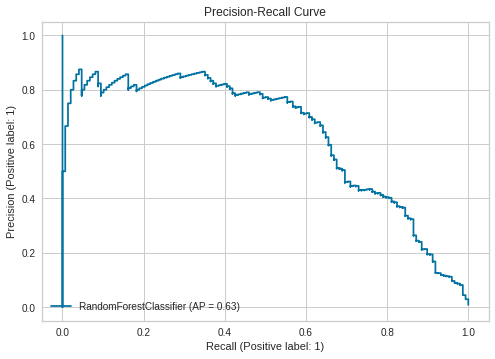

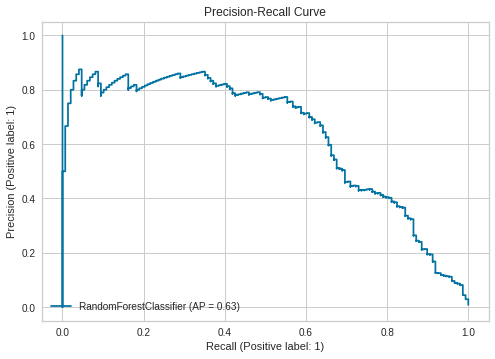

In [ ]:
run = neptune.init_run(
    project='swiatej2/fyp',
    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjOTQxYjBkZS0zN2Y1LTRhYTQtOGQ1My03YTAxODJkM2E1OWMifQ==',
    name='Random Forest Rerun',
    description='rerunning final RF model with the updated transition variable',

)

final_scores, final_plots = score_model(final_model, X_train, X_test, y_train, y_test, df_test)

performance_report(final_scores)

run["algorithm"] = 'Random Forest'
run["params"] = best_params
run['metrics/f1'] = final_scores['f1']
run['metrics/hss'] = final_scores['hss']
run['metrics/transition_f1'] = final_scores['transition_f1']
run['metrics/transition_hss'] = final_scores['transition_hss']
run['features'] = vars_sel

# only include this for compatible models
run['metrics/pr_auc'] = final_scores['pr_auc']

# save Precision-Recall curve plot
img_path = os.path.join(path, 'images/rf_pr_curve.png')
final_plots['pr_plot'].plot()
plt.title("Precision-Recall Curve")
plt.savefig(img_path)

run['plots/pr_curve'].upload(img_path)

run['plots/confusion_matrix'] = npt_utils.create_confusion_matrix_chart(final_model, X_train, X_test, y_train, y_test)

run.stop()


In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/swiatej2/fyp/e/FYP-53/metadata
